# Anomaly detection

We'll demonstrate how an autoencoder can be used to determine anomalies in electrocardiograms.

_Disclaimer: This application is built for demonstration purposes only. It is not intended for use in any medical setting._

## The ECG dataset

I will use the ECG dataset, which contains 4998 examples of electrocardiogram (ECG) signals. The dataset is available for download as a csv file either at http://www.timeseriesclassification.com/description.php?Dataset=ECG5000 or via the Google cloud storage http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv. 
I will use the latter direction to get the dataset. 

In [1]:
import pandas as pd  

dataframe = pd.read_csv("ecg.csv", header=None)
raw_data = dataframe.values

print(f"Size = {raw_data.shape}")

Size = (4998, 141)


C:\Users\GU\AppData\Local\Temp\ipykernel_40176\2527851406.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Each ECG trace has 140 points, plus one last datapoint that represents the label ('0' for anomalous and '1' for normal).
I will separate the labels from the actual traces. I will cut out the beginning and the end of the traces so that they can be used with the autoencoder architecture that I will define later. 
Last, I will randomly split the dataset into training (70%) and test (30%). 


In [2]:
import deeptrack as dt
import numpy as np
import torch

ecgs = raw_data[:, 2:-11]
labels = raw_data[:, -1].astype(bool)

# Create sources
sources = dt.sources.Source(ecg=ecgs, is_normal=labels)
# Split into train and test
train_sources, test_sources = dt.sources.random_split(sources, [0.7, 0.3])
# Extract normal ECGs from train set
normal_sources = train_sources.filter(lambda ecg, is_normal: is_normal)

print(f"Number of normal ECGs = {len(normal_sources)} / {len(train_sources)}")


Number of normal ECGs = 2080 / 3499


In [3]:
min_normal_ecgs = np.min([source["ecg"] for source in normal_sources])
max_normal_ecgs = np.max([source["ecg"] for source in normal_sources])

ecg_pipeline = (
    dt.Value(sources.ecg - min_normal_ecgs) / (max_normal_ecgs - min_normal_ecgs)
    >> dt.Unsqueeze(axis=0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

label_pipeline = dt.Value(sources.is_normal)

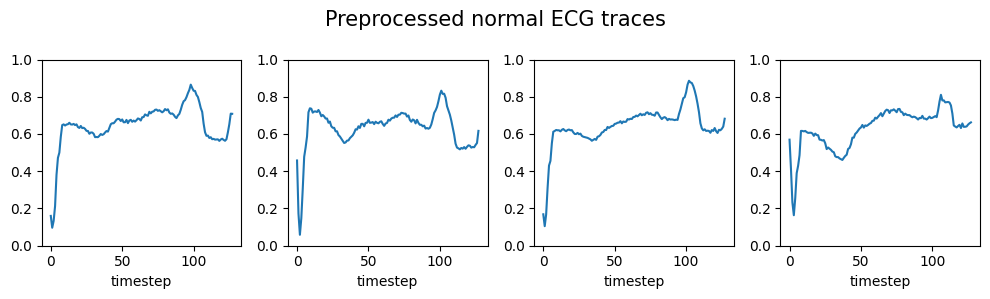

In [4]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=((10, 3)))
fig.suptitle("Preprocessed normal ECG traces", fontsize=15)
for idx, ax in enumerate(axs.ravel()):
    ecg = ecg_pipeline(normal_sources[idx])
    ax.plot(ecg.squeeze())
    ax.set_xlabel("timestep")
    ax.set_ylim([0, 1])

fig.tight_layout()
plt.show()

I will visualize some of the traces of the dataset after preprocessing.

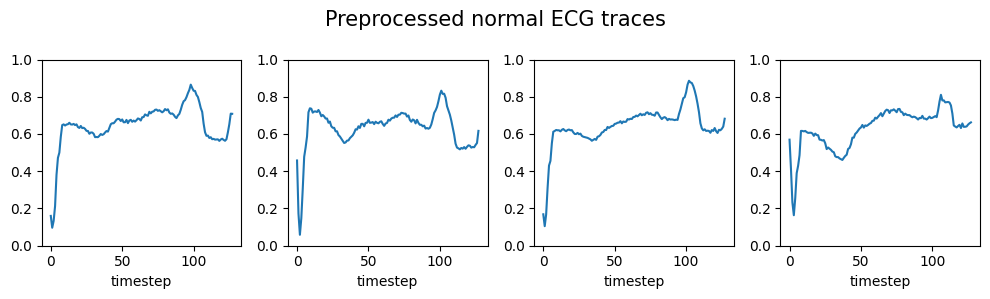

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=((10, 3)))
fig.suptitle("Preprocessed normal ECG traces", fontsize=15)
for idx, ax in enumerate(axs.ravel()):
    ecg = ecg_pipeline(normal_sources[idx])
    ax.plot(ecg.squeeze())
    ax.set_xlabel("timestep")
    ax.set_ylim([0, 1])

fig.tight_layout()
plt.show()

## Autoencoder
I will train a convolutional autoencoder to reconstruct only normal ECG traces by minimizing the reconstruction error. 
The autoencoder's latent space is ideally kept at a low dimensionality to focus on capturing the most salient features while suppressing less relevant or noisy information.

I implement a simple convolutional autoencoder in 1D using as a backbone the `ConvolutionalEncoderDecoder2d` of `deeplay`.
<!-- A similar exercise, using a dense autoencoder can be found at \href{https://www.tensorflow.org/tutorials/generative/autoencoder}. -->

In [6]:
import deeplay as dl
from torch.nn import Identity
import torch.nn as nn

### BM: we should add ConvolutionalEncoderDecoder1d instead of making ConvolutionalEncoderDecoder2d work with 1d data
autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[8, 8],
    decoder_channels=[8, 8],
    out_channels=1,
    out_activation=Identity,
)
autoencoder["encoder|decoder", ..., "layer"].configure(
    nn.Conv1d, kernel_size=4, padding="same"                                                        ### BM: padding="same" with even kernel size gives warnings.
)
autoencoder[..., "pool#1:"].configure(
    nn.MaxPool1d, kernel_size=4, stride=4
)
autoencoder[..., "upsample#:-1"].configure(
    nn.ConvTranspose1d, kernel_size=4, stride=4
)

print(autoencoder)


ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv1d](in_channels=1, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=8)
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): Layer[MaxPool1d](kernel_size=4, stride=4)
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=8)
      )
    )
    (postprocess): Layer[Identity]()
  )
  (decoder): ConvolutionalDecoder2d(
    (preprocess): Layer[Identity]()
    (blocks): LayerList(
      (0-1): 2 x LayerActivationNormalizationUpsample(
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activ

We will train the model by minimizing the reconstruction error through the L1 loss,

In [7]:
from torch.nn import L1Loss

regressor_template = dl.Regressor(
    model=autoencoder, loss=L1Loss(), optimizer=dl.Adam(),
)
ae = regressor_template.create()

We define the dataset and the dataloader. We train for 30 epochs with a batch size of 16. 

In [8]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(ecg_pipeline & ecg_pipeline, inputs=normal_sources)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
autoencoder_trainer = dl.Trainer(max_epochs=30, accelerator="auto")
autoencoder_trainer.fit(ae, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
C:\Users\GU\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.se

Epoch 0:   0%|          | 0/130 [00:00<?, ?it/s] 

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 29: 100%|██████████| 130/130 [00:01<00:00, 116.07it/s, v_num=5, train_loss_step=0.0147, train_loss_epoch=0.0149]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 130/130 [00:01<00:00, 114.49it/s, v_num=5, train_loss_step=0.0147, train_loss_epoch=0.0149]


We show a few reconstructed traces together with the model input. The trained model has learned the main features of the normal traces, whereas is not able to generalize to anomalous traces, offering a poor reconstruction. It can also be observed that the reduced number of weights used by the model also produces reconstructed traces that are very similar among them, with only subtle differences. 


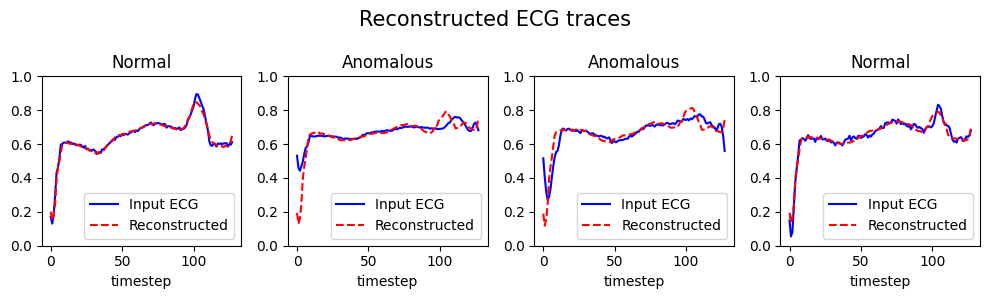

In [9]:
fig, axs = plt.subplots(1, 4, figsize=((10, 3)))
fig.suptitle("Reconstructed ECG traces", fontsize=15)
for ax, source in zip(axs.ravel(), np.random.choice(test_sources, 5)):
    test_ecg, test_label = (ecg_pipeline & label_pipeline)(source)
    pred_ecg = ae(test_ecg.float().unsqueeze(0))
    ax.plot(test_ecg.squeeze(), c="b", label="Input ECG")
    ax.plot(pred_ecg.detach().squeeze(), c="r", ls="--", label="Reconstructed")
    [ax.set_title("Normal") if test_label else ax.set_title("Anomalous")]
    ax.legend()
    ax.set_xlabel("timestep")
    ax.set_ylim([0, 1])

fig.tight_layout()
plt.show()

## Anomaly detection

The distribution of the reconstruction metrics obtained for the training dataset can be used to calculate a threshold (e.g., the 90% quantile) to discriminate between normal and anomalous traces based on the reconstruction error. 


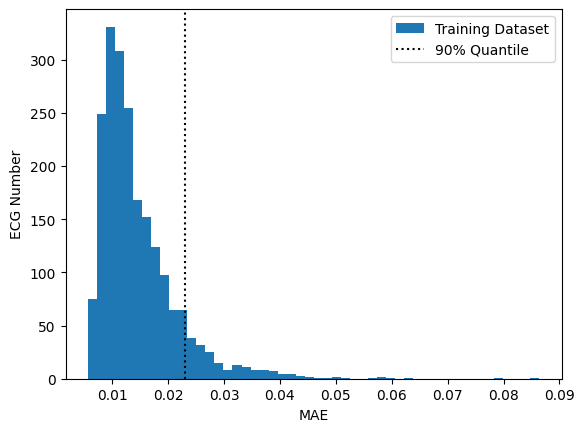

In [10]:
from torch.nn.functional import l1_loss

normal_train_ecgs_tensor = torch.stack([ecg_pipeline(source) for source in normal_sources])
normal_train_preds = ae(normal_train_ecgs_tensor).detach()
normal_train_losses = [l1_loss(ecg, pred) for ecg, pred
                       in zip(normal_train_ecgs_tensor, normal_train_preds)]

threshold_losses = np.quantile(normal_train_losses, 0.9)

plt.hist(normal_train_losses, bins=50, label="Training Dataset")
plt.axvline(x=threshold_losses, color="k", linestyle=":", label="90% Quantile")
plt.xlabel("MAE")
plt.ylabel("ECG Number")
plt.legend()
plt.show()

We'll calculate th reconstruction error on the test dataset. We observe a bimodal distribution with a second peak at values larger than the threshold we have calculated from the training dataset. These values should mainly correspond to anomalous traces that have been poorly reconstructed.

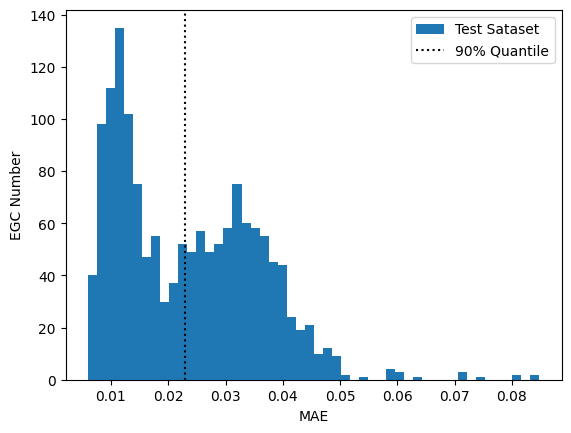

In [11]:
test_ecgs_tensor = torch.stack([ecg_pipeline(source) for source in test_sources])
test_preds = ae(test_ecgs_tensor).detach()
test_losses = [l1_loss(ecg, pred) for ecg, pred 
               in zip(test_ecgs_tensor, test_preds)]

plt.hist(test_losses, bins=50, label="Test Sataset")
plt.axvline(x=threshold_losses, color="k", linestyle=":", label="90% Quantile")
plt.xlabel("MAE")
plt.ylabel("EGC Number")
plt.legend()
plt.show()

We will classify the traces of the test dataset based on the threshold value and calculate several classification metrics, such as the accuracy, the precision, and the recall. 

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

test_labels = [label_pipeline(source) for source in test_sources]
test_pred_labels = test_losses < threshold_losses

print(f"Accuracy = {accuracy_score(test_labels, test_pred_labels)}")
print(f"Precision = {precision_score(test_labels, test_pred_labels)}")
print(f"Recall = {recall_score(test_labels, test_pred_labels)}")

Accuracy = 0.923949299533022
Precision = 0.9713914174252276
Recall = 0.8903456495828367


## Latent space-based anomaly detection

We apply the model to get the intermediate outputs of both the training and the test datasets.

In [13]:
latent_space_normal_train = ae.model.encoder(normal_train_ecgs_tensor).detach()
latent_space_normal_train = (latent_space_normal_train
                             .view(latent_space_normal_train.shape[0], -1))

latent_space_test = ae.model.encoder(test_ecgs_tensor).detach()
latent_space_test = latent_space_test.view(latent_space_test.shape[0], -1)

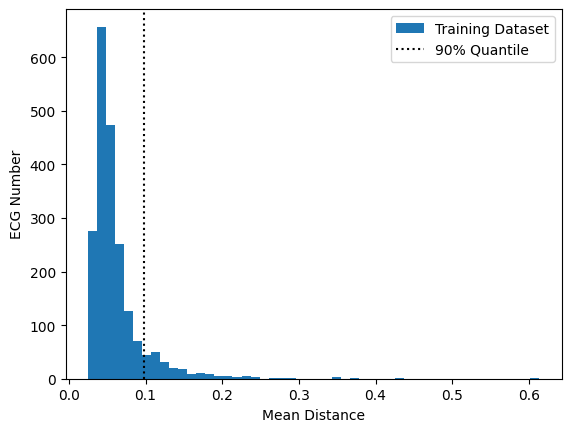

In [14]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 4  # Number of nearest neighbors.

neighbors = (NearestNeighbors(n_neighbors=n_neighbors + 1, 
                              algorithm="ball_tree")
             .fit(latent_space_normal_train))
distances, _ = neighbors.kneighbors(latent_space_normal_train)
distances = distances[:, 1:]
mean_distance = np.mean(distances, 1)

threshold_dist = np.quantile(mean_distance, 0.9)

plt.hist(mean_distance, bins=50, label="Training Dataset")
plt.axvline(x=threshold_dist, color="k", linestyle=":", label="90% Quantile")
plt.xlabel("Mean Distance")
plt.ylabel("ECG Number")
plt.legend()
plt.show()

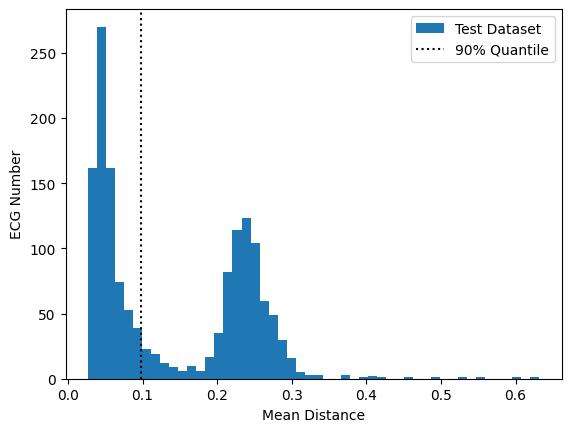

In [15]:
from sklearn.metrics import pairwise_distances

mean_dist_test = pairwise_distances(latent_space_test, 
                                    latent_space_normal_train)
mean_dist_test = np.mean(np.partition(mean_dist_test, n_neighbors, axis=1)[:, :n_neighbors], 1)

plt.hist(mean_dist_test, bins=50, label="Test Dataset")
plt.axvline(x=threshold_dist, color="k", linestyle=":", label="90% Quantile")
plt.xlabel("Mean Distance")
plt.ylabel("ECG Number")
plt.legend()
plt.show()

In [16]:
predictions = np.ones_like(test_labels)
predictions[mean_dist_test > threshold_dist] = 0

print(f"Accuracy = {accuracy_score(test_labels, predictions)}")
print(f"Precision = {precision_score(test_labels, predictions)}")
print(f"Recall = {recall_score(test_labels, predictions)}")

Accuracy = 0.9399599733155437
Precision = 0.9960264900662251
Recall = 0.8963051251489869
